In [1]:
import numpy as np
import os

print('numpy version: {}'.format(np.__version__))

# print the current working directory
print('cwd: {}'.format(os.getcwd()))

numpy version: 1.23.5
cwd: /home/alfred/nicolas/IACG/edgestuff/MNISTonEDGE


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from torchsummary import summary
import onnx
import onnxruntime
# # import tensorflow_addons as tfa
# from onnx_tf.backend import prepare
import sys
from tqdm import tqdm

#  enable benchmarking
torch.backends.cudnn.benchmark = True

mydevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(mydevice)

cuda:0


# train a convnet model

In [3]:
# light model for mnist
# convnet = nn.Sequential( nn.Conv2d(1,1,3), nn.ReLU(), nn.Conv2d(1,1,3), nn.ReLU(), nn.Flatten(), nn.Linear(24*24,10) ).to(mydevice)
# convnet = nn.Sequential( nn.Conv2d(1,1,5), nn.ReLU(), nn.Conv2d(1,1,5), nn.ReLU(),nn.Conv2d(1,1,5), nn.ReLU(),nn.Conv2d(1,1,5), nn.ReLU(),nn.Conv2d(1,1,5), nn.ReLU(),
#  nn.Flatten(), nn.Linear(8*8,64), nn.ReLU(),nn.Linear(64,10)).to(mydevice)
class resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rel = nn.ReLU()
        self.conv0 = nn.Conv2d(1,1,7) # 22*22
        self.conv1 = nn.Conv2d(1,1,3, padding=1)
        self.conv2 = nn.Conv2d(1,1,3, padding=1)
        self.conv3 = nn.Conv2d(1,1,3, padding=1)
        self.conv4 = nn.Conv2d(1,1,5)            # 18*18
        self.conv5 = nn.Conv2d(1,1,3, padding=1)
        self.conv6 = nn.Conv2d(1,1,3, padding=1)
        self.conv7 = nn.Conv2d(1,1,3, padding=1)
        self.conv8 = nn.Conv2d(1,1,5)           # 16*16
        self.conv9 = nn.Conv2d(1,1,3, padding=1)
        self.conv10 = nn.Conv2d(1,1,3, padding=1)
        self.conv11 = nn.Conv2d(1,1,3, padding=1)
        self.conv12 = nn.Conv2d(1,1,5)         # 12*12
        self.fc1 = nn.Linear(100, 10)

        # init the weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.rel(self.conv0(x))
        x1 = self.rel(self.conv1(x))
        x2 = self.rel(self.conv2(x1))
        x3 = self.rel(self.conv3(x2))
        x = x + x3
        x = self.rel(self.conv4(x))
        x1 = self.rel(self.conv5(x))
        x2 = self.rel(self.conv6(x1))
        x3 = self.rel(self.conv7(x2))
        x = x + x3
        x = self.rel(self.conv8(x))
        x1 = self.rel(self.conv9(x))
        x2 = self.rel(self.conv10(x1))
        x3 = self.rel(self.conv11(x2))
        x = x + x3
        x = self.rel(self.conv12(x))
        # x = x.view(-1, 12*12)
        x = nn.Flatten()(x)
        # print(x.shape)
        x = self.fc1(x)
        return x

convnet = resnet().to(mydevice)
# convnet = nn.Sequential( nn.Flatten(), nn.Linear(28*28, 256), nn.ReLU(), nn.Linear(256, 100), nn.ReLU(), nn.Linear(100,10) ).to(mydevice)

#  print the operators
summary(convnet, (1,28,28))
# summary(mlp, (1,28,28))

optim = torch.optim.AdamW(convnet.parameters(), lr=0.01)
critereon = nn.CrossEntropyLoss().to(mydevice)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, verbose=True)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 22, 22]           50
├─ReLU: 1-2                              [-1, 1, 22, 22]           --
├─Conv2d: 1-3                            [-1, 1, 22, 22]           10
├─ReLU: 1-4                              [-1, 1, 22, 22]           --
├─Conv2d: 1-5                            [-1, 1, 22, 22]           10
├─ReLU: 1-6                              [-1, 1, 22, 22]           --
├─Conv2d: 1-7                            [-1, 1, 22, 22]           10
├─ReLU: 1-8                              [-1, 1, 22, 22]           --
├─Conv2d: 1-9                            [-1, 1, 18, 18]           26
├─ReLU: 1-10                             [-1, 1, 18, 18]           --
├─Conv2d: 1-11                           [-1, 1, 18, 18]           10
├─ReLU: 1-12                             [-1, 1, 18, 18]           --
├─Conv2d: 1-13                           [-1, 1, 18, 18]           10
├─ReLU: 1-14   

In [4]:
batchsize = 64

# load MNIST data
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=T.ToTensor())
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=T.ToTensor())

# split into train and validation
total_data = 0.6
val_length = int(len(train_set)*0.1)
train_length = int(len(train_set)) - val_length
train_set, val_set = torch.utils.data.random_split(train_set, [train_length, val_length])
train_set, _ = torch.utils.data.random_split(train_set, [int(len(train_set)*total_data), len(train_set)-int(len(train_set)*total_data)])
val_set, _ = torch.utils.data.random_split(val_set, [int(len(val_set)*total_data), len(val_set)-int(len(val_set)*total_data)])
test_set, _ = torch.utils.data.random_split(test_set, [int(len(test_set)*total_data), len(test_set)-int(len(test_set)*total_data)])
# train_set, val_set = torch.utils.data.random_split(train_set, [train_length, val_length])
# test_set, _ = torch.utils.data.random_split(test_set, [test_length, len(test_set)-test_length])


# create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchsize, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batchsize, shuffle=False)

#  print all the info sizes
print("train set size: ", len(train_set))
print("validation set size: ", len(val_set))
print("test set size: ", len(test_set))
print("train loader size: ", len(train_loader))
print("validation loader size: ", len(val_loader))
print("test loader size: ", len(test_loader))

#  print distribution of classes
def print_class_distribution(loader):
    class_count = [0 for i in range(10)]
    for batch in loader:
        for label in batch[1]:
            class_count[label] += 1
    print(class_count)

print("train set class distribution:")
print_class_distribution(train_loader)
print("validation set class distribution:")
print_class_distribution(val_loader)
print("test set class distribution:")
print_class_distribution(test_loader)


train set size:  32400
validation set size:  3600
test set size:  6000
train loader size:  507
validation loader size:  3600
test loader size:  94
train set class distribution:
[3261, 3601, 3151, 3362, 3141, 2915, 3145, 3329, 3181, 3314]
validation set class distribution:
[349, 421, 355, 372, 358, 331, 367, 370, 363, 314]
test set class distribution:
[557, 706, 599, 595, 601, 544, 582, 592, 595, 629]


In [5]:

best_loss = np.inf

train_losses = []
tain_accs = []
test_losses = []
test_accs = []

weights = []
biases = []
grads = []


# train
for epoch in tqdm(range(30)):
    convnet.train()
    total_loss = 0
    total_acc = 0
    with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
        for x, y in train_loader:
            pbar.update(1)
            x = x.to(mydevice)
            y = y.to(mydevice)
            optim.zero_grad(set_to_none = True)
            y_ = convnet(x)
            loss = critereon(y_, y)
            total_acc += (y_.argmax(dim=1) == y).sum().item()
            loss.backward()
            optim.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
        tain_accs.append(total_acc / len(train_set))
        # print(f"epoch {epoch} train loss {total_loss / len(train_loader)}")
        pbar.set_description(f"epoch {epoch} train acc {total_acc / len(train_set):.3f}")
        pbar.refresh()
    # if epoch % 2 == 0:
    #     weights.append(convnet[0].weight.detach().cpu().numpy())
    #     biases.append(convnet[0].bias.detach().cpu().numpy())
    #     grads.append(convnet[0].weight.grad.detach().cpu().numpy())
    
    # test
    convnet.eval()
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        with tqdm(total=len(test_loader), file=sys.stdout) as pbar:
            for x, y in test_loader:
                pbar.update(1)
                x = x.to(mydevice)
                y = y.to(mydevice)
                y_ = convnet(x)
                loss = critereon(y_, y)
                total_acc += (y_.argmax(dim=1) == y).sum().item()
                total_loss += loss.item()
            test_losses.append(total_loss / len(test_loader))
            test_accs.append(total_acc / len(test_set))
            # print(f"epoch {epoch} test loss {total_loss / len(test_loader)}")
            pbar.set_description(f"epoch {epoch} test acc {total_acc / len(test_set):.3f}")
            pbar.refresh()
            if total_loss < best_loss:
                best_loss = total_loss
                torch.save(convnet.state_dict(), "convnet.pt")
                # print("saved model")
        scheduler.step(total_loss / len(test_loader))



  0%|          | 0/30 [00:00<?, ?it/s]

epoch 0 test acc 0.865: 100%|██████████| 94/94 [00:00<00:00, 210.99it/s]

  3%|▎         | 1/30 [00:04<02:14,  4.63s/it]


epoch 1 test acc 0.887: 100%|██████████| 94/94 [00:00<00:00, 208.20it/s]

  7%|▋         | 2/30 [00:09<02:08,  4.60s/it]


epoch 2 test acc 0.874: 100%|██████████| 94/94 [00:00<00:00, 202.26it/s]

 10%|█         | 3/30 [00:13<02:04,  4.61s/it]


epoch 3 test acc 0.888: 100%|██████████| 94/94 [00:00<00:00, 210.07it/s]

 13%|█▎        | 4/30 [00:18<01:58,  4.57s/it]


epoch 4 test acc 0.918: 100%|██████████| 94/94 [00:00<00:00, 207.28it/s]

 17%|█▋        | 5/30 [00:22<01:54,  4.58s/it]


epoch 5 test acc 0.916: 100%|██████████| 94/94 [00:00<00:00, 213.07it/s]

 20%|██        | 6/30 [00:27<01:49,  4.56s/it]


epoch 6 test acc 0.907: 100%|██████████| 94/94 [00:00<00:00, 206.86it/s]

 23%|██▎       | 7/30 [00:32<01:44,  4.56s/it]


epoch 7 test acc 0.903: 100%|██████████| 94/94 [00:00<00:00, 208.93it/s]

 27%|██▋       | 8/30 [00:36<01:40,  4.57s/it]


epoch 8 test acc 0.924: 100%|██████████| 94/94 [00:00<00:00, 208.45it/s]

 30%|███       | 9/30 [00:41<01:36,  4.57s/it]


epoch 9 test acc 0.913: 100%|██████████| 94/94 [00:00<00:00, 212.16it/s]

 33%|███▎      | 10/30 [00:45<01:31,  4.56s/it]


epoch 10 test acc 0.927: 100%|██████████| 94/94 [00:00<00:00, 208.33it/s]

 37%|███▋      | 11/30 [00:50<01:26,  4.56s/it]


epoch 11 test acc 0.919: 100%|██████████| 94/94 [00:00<00:00, 207.98it/s]

 40%|████      | 12/30 [00:54<01:21,  4.55s/it]


epoch 12 test acc 0.925: 100%|██████████| 94/94 [00:00<00:00, 211.05it/s]

 43%|████▎     | 13/30 [00:59<01:17,  4.54s/it]


epoch 13 test acc 0.934: 100%|██████████| 94/94 [00:00<00:00, 207.79it/s]

 47%|████▋     | 14/30 [01:03<01:12,  4.54s/it]


epoch 14 test acc 0.919: 100%|██████████| 94/94 [00:00<00:00, 207.71it/s]

 50%|█████     | 15/30 [01:08<01:08,  4.56s/it]


epoch 15 test acc 0.929: 100%|██████████| 94/94 [00:00<00:00, 206.00it/s]

 53%|█████▎    | 16/30 [01:12<01:03,  4.55s/it]


epoch 16 test acc 0.934: 100%|██████████| 94/94 [00:00<00:00, 213.35it/s]

 57%|█████▋    | 17/30 [01:17<00:59,  4.55s/it]


epoch 17 test acc 0.926: 100%|██████████| 94/94 [00:00<00:00, 204.99it/s]

 60%|██████    | 18/30 [01:22<00:54,  4.54s/it]


epoch 18 test acc 0.923: 100%|██████████| 94/94 [00:00<00:00, 213.50it/s]

 63%|██████▎   | 19/30 [01:26<00:50,  4.55s/it]


epoch 19 test acc 0.922: 100%|██████████| 94/94 [00:00<00:00, 213.39it/s]

 67%|██████▋   | 20/30 [01:31<00:45,  4.53s/it]


Epoch 00020: reducing learning rate of group 0 to 1.0000e-03.
epoch 20 test acc 0.945: 100%|██████████| 94/94 [00:00<00:00, 207.66it/s]

 70%|███████   | 21/30 [01:35<00:40,  4.53s/it]


epoch 21 test acc 0.949: 100%|██████████| 94/94 [00:00<00:00, 212.92it/s]

 73%|███████▎  | 22/30 [01:40<00:36,  4.56s/it]


epoch 22 test acc 0.946: 100%|██████████| 94/94 [00:00<00:00, 213.78it/s]

 77%|███████▋  | 23/30 [01:44<00:31,  4.55s/it]


epoch 23 test acc 0.945: 100%|██████████| 94/94 [00:00<00:00, 214.44it/s]

 80%|████████  | 24/30 [01:49<00:27,  4.53s/it]


epoch 24 test acc 0.948: 100%|██████████| 94/94 [00:00<00:00, 202.44it/s]

 83%|████████▎ | 25/30 [01:53<00:22,  4.54s/it]


epoch 25 test acc 0.946: 100%|██████████| 94/94 [00:00<00:00, 207.19it/s]

 87%|████████▋ | 26/30 [01:58<00:18,  4.56s/it]


epoch 26 test acc 0.948: 100%|██████████| 94/94 [00:00<00:00, 212.46it/s]

 90%|█████████ | 27/30 [02:03<00:13,  4.56s/it]


epoch 27 test acc 0.950: 100%|██████████| 94/94 [00:00<00:00, 208.39it/s]

 93%|█████████▎| 28/30 [02:07<00:09,  4.57s/it]


epoch 28 test acc 0.948: 100%|██████████| 94/94 [00:00<00:00, 203.84it/s]

 97%|█████████▋| 29/30 [02:12<00:04,  4.57s/it]


epoch 29 test acc 0.946: 100%|██████████| 94/94 [00:00<00:00, 214.17it/s]

100%|██████████| 30/30 [02:16<00:00,  4.56s/it]

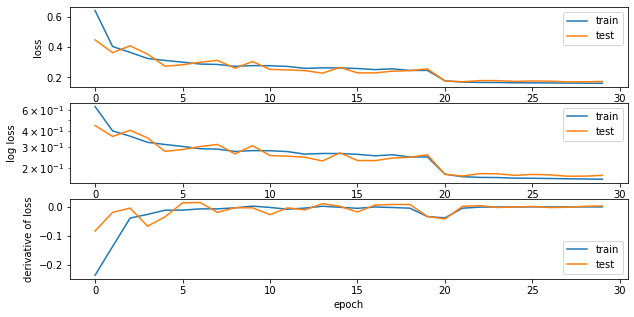

In [9]:
# plot
#  set size
plt.figure(figsize=(10, 5))
#  losses
plt.subplot(3, 1, 1)
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

#  log losses
plt.subplot(3, 1, 2)
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.yscale("log")
plt.ylabel("log loss")
plt.xlabel("epoch")
plt.legend()

#  derivative of loss
plt.subplot(3, 1, 3)
plt.plot(np.gradient(train_losses), label="train")
plt.plot(np.gradient(test_losses), label="test")
plt.ylabel("derivative of loss")
plt.xlabel("epoch")
plt.legend()

plt.show()

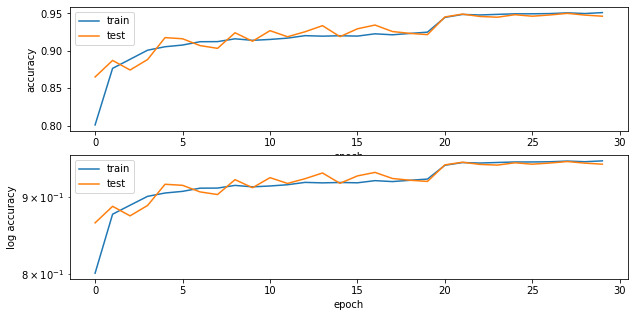

In [10]:
#  plot accuracy
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(tain_accs, label="train")
plt.plot(test_accs, label="test")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tain_accs, label="train")
plt.plot(test_accs, label="test")
plt.yscale("log")
plt.ylabel("log accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()


# evaluate the raw model

100%|██████████| 3600/3600 [00:05<00:00, 638.51it/s]


raw model accuracy: 0.9547222222222222
raw model class accuracy: [0.09527777777777778, 0.11555555555555555, 0.095, 0.0975, 0.09527777777777778, 0.0875, 0.09972222222222223, 0.0975, 0.09305555555555556, 0.07833333333333334]


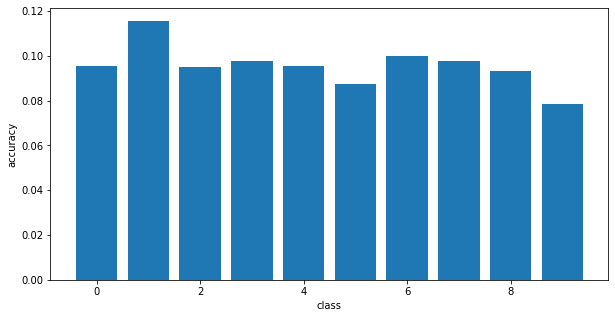

In [5]:
# evaluatre the model
convnet.load_state_dict(torch.load("convnet.pt"))
convnet.eval()

#  estimate accuracy on valid set of raw model
total_acc = 0
class_acc = [0 for _ in range(10)]
with torch.no_grad():
    for x,y in tqdm(val_loader):
        x,y = x.to(mydevice), y.to(mydevice)

        y_ = convnet(x)
        loss = critereon(y_, y)
        total_acc+= (y_.argmax(dim=1) == y).sum().item()
        for i in range(10):
            class_acc[i] += ((y_.argmax(dim=1) == y) & (y == i)).sum().item()
total_acc /= len(val_set)
class_acc = [x / len(val_set) for x in class_acc]
print(f"raw model accuracy: {total_acc}")
print(f"raw model class accuracy: {class_acc}")


#  graph class accuracy in a bar chart
plt.figure(figsize=(10, 5))
plt.bar(range(10), class_acc)
plt.xlabel("class")
plt.ylabel("accuracy")
plt.show()


# quantization

In [ ]:
# #  now we quantize the model
# convnet.load_state_dict(torch.load("convnet.pt"))

# # static quantization
# convnet.qconfig = torch.quantization.get_default_qconfig('fbgemm')
# torch.quantization.prepare(convnet, inplace=True)
# torch.quantization.convert(convnet, inplace=True)

# #  estimate accuracy on valid set of quantized model
# total_acc = 0
# class_acc = [0 for _ in range(10)]
# with torch.no_grad():
#     for x,y in tqdm(val_loader):
#         x,y = x.to(mydevice), y.to(mydevice)

#         y_ = convnet(x)
#         loss = critereon(y_, y)
#         total_acc+= (y_.argmax(dim=1) == y).sum().item()
#         for i in range(10):
#             class_acc[i] += ((y_.argmax(dim=1) == y) & (y == i)).sum().item()
# total_acc /= len(val_set)
# class_acc = [x / len(val_set) for x in class_acc]
# print(f"quantized model accuracy: {total_acc}")
# print(f"quantized model class accuracy: {class_acc}")

# #  graph class accuracy in a bar chart
# plt.figure(figsize=(10, 5))
# plt.bar(range(10), class_acc)
# plt.xlabel("class")
# plt.ylabel("accuracy")
# plt.show()

#!  we quantize the model in onnx



In [6]:
def get_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")
    os.remove('temp.p')
    return size

In [ ]:
# #  evaluate on a grid
# x = torch.linspace(-10, 10, 1000).unsqueeze(1).to(mydevice) 
# y = torch.sin(x).to(mydevice)
# y_ = quantized_model(x).to(mydevice)

# #  plot the results
# plt.plot(x.cpu().numpy(), y.cpu().numpy(), label="sin(x)")
# plt.plot(x.cpu().numpy(), y_.cpu().detach().numpy(), label="model")
# plt.legend()
# plt.show()

# Qerror = 0

# #  calculate the error
# with torch.no_grad():
#     Qerror = torch.mean(torch.abs(y - y_))
#     print(f"error {Qerror}")

# print(f"error reduction {rawerror / Qerror}")
# print(f"abs error reduction {abs(rawerror - Qerror)}")
# print(f"model size {get_size_of_model(sineModel)}")
# print(f"quantized model size {get_size_of_model(quantized_model)}")


# print(quantized_model)
# # summary(quantized_model, (1,))


In [ ]:
# #  save the model
# torch.jit.save(torch.jit.script(quantized_model), "Q_sineModel.pt")

# export to onnx

torch.Size([1, 1, 28, 28])
Exported graph: graph(%input : Float(1, 1, 28, 28, strides=[1, 1, 28, 1], requires_grad=0, device=cpu),
      %conv0.weight : Float(1, 1, 7, 7, strides=[49, 49, 7, 1], requires_grad=1, device=cpu),
      %conv0.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %conv1.weight : Float(1, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %conv1.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %conv2.weight : Float(1, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %conv2.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %conv3.weight : Float(1, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %conv3.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %conv4.weight : Float(1, 1, 5, 5, strides=[25, 25, 5, 1], requires_grad=1, device=cpu),
      %conv4.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %conv5.weight : Float(1, 1, 3, 3, strid

100%|██████████| 3600/3600 [00:03<00:00, 1035.01it/s]


onnx model accuracy: 0.9547222222222222
onnx model class accuracy: [0.09527777777777778, 0.11555555555555555, 0.095, 0.0975, 0.09527777777777778, 0.0875, 0.09972222222222223, 0.0975, 0.09305555555555556, 0.07833333333333334]


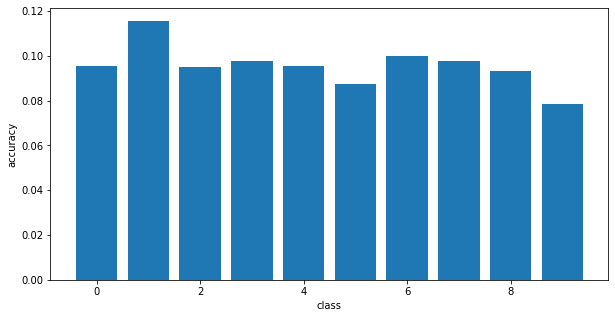

In [6]:
# export to onnx
convnet.load_state_dict(torch.load("convnet.pt"))
convnet = convnet.cpu()
convnet.eval()
# dummy_input = torch.randn(1, 1, 28, 28)
# use valiadtion set as dummy input
dummy_input = val_set[0][0].unsqueeze(0)
print(dummy_input.shape)
torch.onnx.export(convnet,
    dummy_input,
    "convnet.onnx",
    verbose=True,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"])


#  test the model
onnx_model = onnx.load("convnet.onnx")
print("model exported")
onnx.checker.check_model(onnx_model)
print("model checked")
#  print a human readable representation of the graph
onnx.helper.printable_graph(onnx_model.graph)
print("strating inference")
ort_session = onnxruntime.InferenceSession("convnet.onnx")

# compute ONNX Runtime output prediction
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


#  estimate accuracy on valid set of onnx model
total_acc = 0
class_acc = [0 for _ in range(10)]
with torch.no_grad():
    for x,y in tqdm(val_loader):
        x,y = x.to(mydevice), y.to(mydevice)

        # x = x.
        # print(x.shape)
        ort_inputs = {ort_session.get_inputs()[0].name: to_numpy( x)}
        ort_outs = ort_session.run(["output"], ort_inputs)
        y_ = torch.from_numpy(ort_outs[0]).to(mydevice)
        loss = critereon(y_, y)
        total_acc+= (y_.argmax(dim=1) == y).sum().item()
        for i in range(10):
            class_acc[i] += ((y_.argmax(dim=1) == y) & (y == i)).sum().item()
total_acc /= len(val_set)
class_acc = [x / len(val_set) for x in class_acc]
print(f"onnx model accuracy: {total_acc}")
print(f"onnx model class accuracy: {class_acc}")

#  graph class accuracy in a bar chart
plt.figure(figsize=(10, 5))
plt.bar(range(10), class_acc)
plt.xlabel("class")
plt.ylabel("accuracy")
plt.show()




In [ ]:
#  model summary
# summary(Q_sineModel, (1,))


In [ ]:
# # export the model
# import torch._C as _C
# OperatorExportTypes = _C._onnx.OperatorExportTypes
# # torch.onnx.export(torch.jit.script(Q_sineModel), x, "Q_sineModel.onnx", opset_version=11, input_names=["x"], output_names=["y"])

# #  export model to onnx
# torch.onnx.export(convnet,\
#      x,                         # dummy input
#     "sineModel.onnx",           # save path
#     opset_version=11,            # the ONNX version to export the model to
#     # operator_export_type=OperatorExportTypes.ONNX_FALLTHROUGH,
#     export_params=True,         # store the trained parameter weights inside the model file
#     do_constant_folding=True,   # whether to execute constant folding for optimization #! am not sure what this does
#     input_names=["x"],          # the model's input names
#     output_names=["y"]          # the model's output names
#     )



# check onnx model


In [ ]:
# #  run the model using the onnxruntime  
# ort_session = onnxruntime.InferenceSession("sineModel.onnx")

# def to_numpy(tensor):
#     return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# # compute ONNX Runtime output prediction
# ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}  #  x is the input that was defined before
# ort_outs = ort_session.run(None, ort_inputs)

# # compare ONNX Runtime and PyTorch results
# np.testing.assert_allclose(to_numpy(sineModel(x) ), ort_outs[0], rtol=1e-03, atol=1e-05)

# print("Exported model has been tested with ONNXRuntime, and the result looks good!")

In [ ]:
# #  quantize the onnx model
# from onnxruntime.quantization import quantize_dynamic, QuantType

# quantized_model = quantize_dynamic('sineModel.onnx', 'Q_sineModel.onnx', weight_type=QuantType.QUInt8)

# print("Exported model has been quantized with ONNXRuntime, and the result looks good!")
# #  print size of the model
# print(f"Q ONNX model size {os.path.getsize('Q_sineModel.onnx')}")

# #  load the quantized onnx model and test
# onnx_model = onnx.load("Q_sineModel.onnx")

# #  check that the IR is well formed
# print("check that the IR is well formed: ")
# print(onnx.checker.check_model(onnx_model))
# print()
# #  print a human readable representation of the graph
# print(onnx.helper.printable_graph(onnx_model.graph))

# #  run the model using the onnxruntime
# qort_session = onnxruntime.InferenceSession("Q_sineModel.onnx")

# def to_numpy(tensor):
#     return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# # compute ONNX Runtime output prediction
# qort_inputs = {qort_session.get_inputs()[0].name: to_numpy(x)}  #  x is the input that was defined before
# qort_outs = qort_session.run(None, qort_inputs)

# # compare ONNX Runtime and PyTorch results

# rtol_ = 1e-03
# atol_ = 1e-05

# # plot all the results
# plt.subplot(5, 1, 1)
# plt.plot(x.cpu().numpy(), y.cpu().numpy(), label="sin(x)")
# plt.legend()
# plt.subplot(5, 1, 2)
# plt.plot(x.cpu().numpy(), ort_outs[0], label="onnx")
# plt.legend()
# plt.subplot(5, 1, 3)
# plt.plot(x.cpu().numpy(), qort_outs[0], label="quantized onnx")
# plt.legend()
# plt.subplot(5, 1, 4)
# plt.plot(x.cpu().numpy(), to_numpy(sineModel(x)), label="pytorch")
# plt.legend()
# plt.subplot(5, 1, 5)
# plt.plot(x.cpu().numpy(), to_numpy(Q_sineModel(x)), label="quantized pytorch")
# plt.legend()


# try:
#     np.testing.assert_allclose(to_numpy(Q_sineModel(x) ), ort_outs[0], rtol=rtol_, atol=atol_)
#     print("SUCCESS comparasion between original onnx and quantized pytorch model")
# except:
#     print("FAILED comparasion between original onnx and quantized pytorch model")
# # print("Exported model has been tested with ONNXRuntime, and the result looks good!")
# try:
#     np.testing.assert_allclose(to_numpy(sineModel(x) ), ort_outs[0], rtol=rtol_, atol=atol_)
#     print("SUCCESS comparasion between original onnx and original pytorch model")
# except:
#     print("FAILED comparasion between original onnx and original pytorch model")
# # print("Exported model has been tested with ONNXRuntime, and the result looks good!")

# #  compare with original onnx model
# try:
#     np.testing.assert_allclose(ort_outs[0], qort_outs[0], rtol=rtol_, atol=atol_)
#     print("SUCCESS comparasion between original onnx and quantized onnx model")
# except:
#     print("FAILED comparasion between original onnx and quantized onnx model")

# #  compare with original pytorch model
# try:
#     np.testing.assert_allclose(to_numpy(sineModel(x) ), qort_outs[0], rtol=rtol_, atol=atol_)
#     print("SUCCESS comparasion between original pytorch and quantized onnx model")
# except:
#     print("FAILED comparasion between original pytorch and quantized onnx model")

# export to tflite

In [7]:
#  convert the onnx model to tf freezed graph
# import tensorflow as tf

#  load the onnx model
onnx_model = onnx.load("sineModel.onnx")

#  convert the onnx model to tf
tf_rep = prepare(onnx_model)
tf_rep.export_graph("sineModel.pb")

representative_dataset = tf.data.Dataset.from_tensor_slices(x.cpu().numpy()).batch(1)
def representative_dataset_gen():
    for input_value in representative_dataset.take(100):
        # Model has only one input so each data point has one element.
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_saved_model("sineModel.pb")
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.TFLITE_BUILTINS_INT8, # enable TensorFlow Lite ops.
#   tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen

tflite_model = converter.convert()

#  save the model
open("sineModel.tflite", "wb").write(tflite_model)

: 

: 

In [ ]:
#  load the model
interpreter = tf.lite.Interpreter(model_path="Q_sineModel.tflite")
interpreter.allocate_tensors()

#  get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#  test the model
input_data = x.cpu().detach().numpy()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

#  compare the results
try:
    np.testing.assert_allclose(qort_outs[0], tflite_results, rtol=1e-03, atol=1e-05)
except:
    print("FAILED comparasion between quantized onnx and tflite model")

print("Exported model has been tested with tflite, and the result looks good!")
print("size of the tflite model is: ", os.path.getsize("Q_sineModel.tflite"))

In [ ]:
# compare all the sizes
print("size of the original pytorch model is: ", os.path.getsize("sineModel.pt"), " bytes")
print("size of the quantized pytorch model is: ", os.path.getsize("Q_sineModel.pt"), " bytes")
print("size of the original onnx model is: ", os.path.getsize("sineModel.onnx"), " bytes")
print("size of the quantized onnx model is: ", os.path.getsize("Q_sineModel.onnx"), " bytes")
# print("size of the tf model is: ", os.path.getsize("sineModel.pb"), " bytes") # there might be some problem with the tf model
print("size of the tflite model is: ", os.path.getsize("sineModel.tflite"), " bytes")


In [ ]:
#  compare performance
import time

load = 10000

print("for a load of ", load, " samples")

#  pytorch
start = time.time()
for i in range(load):
    to_numpy(sineModel(x))
end = time.time()
print(f" pytorch time: {(end - start):.3f} seconds")
# print("pytorch time: ", end - start, " seconds")

#  quantized pytorch
start = time.time()
for i in range(load):
    to_numpy(Q_sineModel(x))
end = time.time()
print(f" quantized pytorch time: {(end - start):.3f} seconds")
# print("quantized pytorch time: ", end - start, " seconds")

# onnx
start = time.time()
for i in range(load):
    ort_outs = ort_session.run(None, ort_inputs)
end = time.time()
print(f" onnx time: {(end - start):.3f} seconds")
# print("onnx time: ", end - start, " seconds")

#  quantized onnx
start = time.time()
for i in range(load):
    ort_outs = qort_session.run(None, qort_inputs)
end = time.time()
print(f" quantized onnx time: {(end - start):.3f} seconds")
# print("quantized onnx time: ", end - start, " seconds")

#  tflite
start = time.time()
for i in range(load):
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    tflite_results = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
print(f" tflite time: {(end - start):.3f} seconds")
# print("tflite time: ", end - start, " seconds")



In [ ]:
# compare plots
plt.figure(figsize=(10, 10))
plt.subplot(5, 1, 1)
plt.plot(x.cpu().numpy(), ort_outs[0], label="onnx")
plt.legend()
plt.subplot(5, 1, 2)
plt.plot(x.cpu().numpy(), qort_outs[0], label="quantized onnx")
plt.legend()
plt.subplot(5, 1, 3)
plt.plot(x.cpu().numpy(), tflite_results, label="tflite")
plt.legend()
plt.subplot(5, 1, 4)
plt.plot(x.cpu().numpy(), to_numpy(sineModel(x)), label="pytorch")
plt.legend()
plt.subplot(5, 1, 5)
plt.plot(x.cpu().numpy(), to_numpy(Q_sineModel(x)), label="quantized pytorch")
plt.legend()
plt.show()



In [ ]:
! xxd -i sineModel.tflite > tfLite_esp32/src/sineModel.cpp
! cat tfLite_esp32/src/sineModel.cpp